# Spin ice hysteresis

In [1]:
###Imports###
%matplotlib notebook

import numpy as np
import mpmath as mp
mp.dps = 15; mp.pretty = True
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import random

In [2]:
###Global constants###
N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
k_B = 1.38064852 * 10**-23 #Boltzmann constant

In [3]:
###Global variables###
factor = 4 #coupling factor
factor_string = '4'
meta_switch = False #switch for turning off (True) or on (False) the metastable state
hysteresis_switch = True #switch to enable (True) or disable (False) hysteresis

In [4]:
def double_monopole(start_mu, coupling, switch, hysteresis, start_T, num_T, T_max, tol, limit, n_init=0, n_init2=1):

    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    
    ##array initialisation##
    #TempArray_double = []
    TempArray_double = np.geomspace(start_T, T_max, num=num_T)
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    internalEnergyArray = []
    
    ##hysteresis modification##
    if hysteresis == True:
        #appends a reversed TempArray onto the original TempArray
        TempArray_double = np.append(TempArray_double, np.flip(TempArray_double), axis=0)
        num_T = num_T * 2 # correcting the number of T points to match TempArray number of elements
    
    j=0 #variable to cycle through elements of TempArray
    
    old_mu = 0
    new_mu = -start_mu * k_B
    init_mu = -start_mu * k_B
    old_mu_2 = 0
    new_mu_2 = -start_mu * coupling * k_B
    init_mu_2 = -start_mu * coupling * k_B
    
    #while T <= T_max :
    while j < num_T :
        
        i = 0
        old_mu = 0
        old_mu_2 = 0
        #note older versions had lines here that reset the new_mu values
        #this would stop previous temperature steps affecting subsequent ones
        #thus stopping any hysteresis
        beta = 1/(k_B * T)
        l_T = (mu_0 * Q * Q)/(k_B * T * 8 * np.pi)
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new number of monopoles
            n = (4/3 * np.exp(beta * old_mu))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu) + np.exp(beta * old_mu_2))))
            n_2 = (1/3 * np.exp(beta * old_mu_2))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu) + np.exp(beta * old_mu_2))))
            #print("n:", n)
            
            #calculating new charge densities
            ##this 'if' statement was for testing for metastability
            ###however it was written thinking that high density state was metastable
            ####and low density was the actual stable state.
            #####As such if switch is "true" (and default n_init values left unchanged)
            ######the truly metastable low density state is switched off
            #######so it develops from the true stable high density state
            ########and if switch is "false" then system develops from metastable low density state,
            #########as in previous iterations of this code.
            if i == 0 and switch == True:
                #print("metastability on")
                rho = n_init/vol_per_site
                rho_2 = n_init2/vol_per_site
                
            else:
                rho = n/vol_per_site
                rho_2 = n_2/vol_per_site
                
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            
            l_D = np.sqrt((k_B * T)/(Q * Q * rho_I * mu_0)) #Debye length Calc
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = k_B * T * ((l_T)/(l_D + a))
            new_mu = init_mu + deltaDH
            new_mu_2 = init_mu_2 + 4*deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after', limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        ##Calculates the differential of monopole density n wit respect to Temperature, used to calculate specific heat
        #differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * old_mu))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu) + mp.exp((1/(k_B * t)) * old_mu_2) )))), T)
        #differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu) + mp.exp((1/(k_B * t)) * old_mu_2) )))), T)
        
        #dn/dT calculations, long because of the equations being self-consistent
        differential = mp.diff(lambda t:((1/3 * 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))) ))/(1 +(1/3 * ( (4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))))) + mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) ) ))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) + mp.exp((1/(k_B * t)) * (init_mu_2 + coupling * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) )))), T)
        
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        #print("differential of n wrt T:", differential)
        #print("differential of n_2 wrt T:", differential_2)
        #print("Specific Heat Value:", SpecHeatVal)
        
        if (n+n_2) < 1:
            Entropy = - k_B * N_0 *( (n*mp.log(n/2) + (n_2*mp.log(2*n_2) + ((1-n-n_2)*mp.log(1-n-n_2)) + ((1-n-n_2)*mp.log(2/3)) ) ) )
        else:
            Entropy = - k_B * N_0 *(n*mp.log(n/2) + (n_2*mp.log(2*n_2)) )
        #Entropy_corrected = Entropy - (8.314 * 1/2*np.log(3/2))
        
#        if Entropy < 0:
#            Entropy = 0
        
        internalEnergyTerm = np.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        #internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        internalEnergy = - ((4 * N_0 * k_B * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        #TempArray_double = np.append(TempArray_double, T)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        
        #T += T_step
        
        j += 1
        if j < num_T :
            T = TempArray_double[j]
        #print("done")
        
    ##numerical calculation of entropy, omega##
    #DiffNumerical = np.gradient(nArray, TempArray_double)
    #DiffNumerical_2 = np.gradient(n_2Array, TempArray_double)
    #SpecHeatNumerical = - 1/2 * N_0 * (muDoubleArray * DiffNumerical + mu2DoubleArray * DiffNumerical_2)

    #DeltaS = cumtrapz((SpecHeatNumerical)/TempArray_double, TempArray_double)
    #DeltaS = np.insert(DeltaS,0,0, axis=0) #inserts a 0 in 0th element to match other arrays' sizes
    #EntropyTotalArray = DeltaS + (N_0*1/2 * k_B *np.log(3/2))

    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (init_mu_2 * (N_0*n_2Array)) - (TempArray_double*EntropyArray)
        
    print("")
    print("final")
    #print("Temperature values:", TempArray_double)
    #print("Specific Heat array:", SpecHeatArray_double)
    return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, EntropyArray, Omega)

In [ ]:
###Quickrun###

###1.00 mu_1 values, double monopole###
TempArray_double1, SpecHeatArray_double1, EntropyArray_double1, muDoubleArray1, mu2DoubleArray1, nArray_double1, n_2Array_double1, EntropyArray_double1, Omega_double1 = double_monopole(1.30, factor, False, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)


In [5]:
###0.50 mu_1 values, double monopole###
TempArray_double1, SpecHeatArray_double1, EntropyArray_double1, muDoubleArray1, mu2DoubleArray1, nArray_double1, n_2Array_double1, EntropyArray_double1, Omega_double1 = double_monopole(0.50, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###0.75 mu_1 values, double monopole###
TempArray_double9, SpecHeatArray_double9, EntropyArray_double9, muDoubleArray9, mu2DoubleArray9, nArray_double9, n_2Array_double9, EntropyArray_double9, Omega_double9 = double_monopole(0.75, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###1.00 mu_1 values, double monopole###
TempArray_double2, SpecHeatArray_double2, EntropyArray_double2, muDoubleArray2, mu2DoubleArray2, nArray_double2, n_2Array_double2, EntropyArray_double2, Omega_double2 = double_monopole(1.00, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###1.15 mu_1 values, double monopole###
TempArray_double3, SpecHeatArray_double3, EntropyArray_double3, muDoubleArray3, mu2DoubleArray3, nArray_double3, n_2Array_double3, EntropyArray_double3, Omega_double3 = double_monopole(1.15, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###1.30 mu_1 values, double monopole###7
TempArray_double4, SpecHeatArray_double4, EntropyArray_double4, muDoubleArray4, mu2DoubleArray4, nArray_double4, n_2Array_double4, EntropyArray_double4, Omega_double4 = double_monopole(1.30, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###1.57 mu_1 values, double monopole###
TempArray_double5, SpecHeatArray_double5, EntropyArray_double5, muDoubleArray5, mu2DoubleArray5, nArray_double5, n_2Array_double5, EntropyArray_double5, Omega_double5 = double_monopole(1.57, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###1.90 mu_1 values, double monopole###
TempArray_double6, SpecHeatArray_double6, EntropyArray_double6, muDoubleArray6, mu2DoubleArray6, nArray_double6, n_2Array_double6, EntropyArray_double6, Omega_double6 = double_monopole(1.90, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###2.50 mu_1 values, double monopole###
TempArray_double7, SpecHeatArray_double7, EntropyArray_double7, muDoubleArray7, mu2DoubleArray7, nArray_double7, n_2Array_double7, EntropyArray_double7, Omega_double7 = double_monopole(2.50, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###4.35 mu_1 values, double monopole###
TempArray_double8, SpecHeatArray_double8, EntropyArray_double8, muDoubleArray8, mu2DoubleArray8, nArray_double8, n_2Array_double8, EntropyArray_double8, Omega_double8 = double_monopole(4.35, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)



final

final

final

final

final

final

final

final

final


between 1.47 to 1.475 mu magnitude stops wanting to be a high density crystal, returns to gaseous state that it starts in.

In [ ]:
###1.51 mu_1 values, double monopole###
TempArray_double5_1, SpecHeatArray_double5_1, EntropyArray_double5_1, muDoubleArray5_1, mu2DoubleArray5_1, nArray_double5_1, n_2Array_double5_1, EntropyArray_double5_1, Omega_double5_1 = double_monopole(1.40, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###1.55 mu_1 values, double monopole###
TempArray_double5_2, SpecHeatArray_double5_2, EntropyArray_double5_2, muDoubleArray5_2, mu2DoubleArray5_2, nArray_double5_2, n_2Array_double5_2, EntropyArray_double5_2, Omega_double5_2 = double_monopole(1.47, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###1.53 mu_1 values, double monopole###
TempArray_double5_3, SpecHeatArray_double5_3, EntropyArray_double5_3, muDoubleArray5_3, mu2DoubleArray5_3, nArray_double5_3, n_2Array_double5_3, EntropyArray_double5_3, Omega_double5_3 = double_monopole(1.4725, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

###pi mu_1 values, double monopole###
TempArray_double5_4, SpecHeatArray_double5_4, EntropyArray_double5_4, muDoubleArray5_4, mu2DoubleArray5_4, nArray_double5_4, n_2Array_double5_4, EntropyArray_double5_4, Omega_double5_4 = double_monopole(np.pi, factor, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)


In [ ]:
###monopole density against inverse temperature###
graph1= plt.figure()
plt.grid(True)

plt.plot(1/TempArray_double1, nArray_double1 + n_2Array_double1, '-', label="$\mu=0.50$, $n+n_2$")
plt.plot(1/TempArray_double9, nArray_double9 + n_2Array_double9, '-', label="$\mu=0.75$, $n+n_2$")
plt.plot(1/TempArray_double2, nArray_double2 + n_2Array_double2, '-', label="$\mu=1.00$, $n+n_2$")
plt.plot(1/TempArray_double3, nArray_double3 + n_2Array_double3, '-', label="$\mu=1.15$, $n+n_2$")
plt.plot(1/TempArray_double4, nArray_double4 + n_2Array_double4, '-', label="$\mu=1.30$, $n+n_2$")
plt.plot(1/TempArray_double5, nArray_double5 + n_2Array_double5, '-', label="$\mu=1.57$, $n+n_2$")
plt.plot(1/TempArray_double6, nArray_double6 + n_2Array_double6, '-', label="$\mu=1.90$, $n+n_2$")
plt.plot(1/TempArray_double7, nArray_double7 + n_2Array_double7, '-', label="$\mu=2.50$, $n+n_2$")
plt.plot(1/TempArray_double8, nArray_double8 + n_2Array_double8, '-', label="$\mu=4.35$, $n+n_2$")

plt.xlabel("1/Temperature ($K^{-1}$)")
plt.ylabel("monopole density per site")
plt.yscale('log')
#plt.ylim(0.175,0.275)
#plt.xlim(6, 6.6)
#plt.ylim(10**-4,1)
#plt.xlim(0,80)
#plt.ylim(10**-5, 5)
#plt.xlim(0,40)
plt.title(str(factor) + " factor double model monopole densities against inverse temperature")
plt.legend(loc='lower left')


graph_string = ' factor  monopole densities against inverse temperature double model.png'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)

In [ ]:
###monopole density against temperature###
graph1= plt.figure()
plt.grid(True)

plt.plot(1/TempArray_double1, nArray_double1 , '-', label="$\mu=0.50$")
plt.plot(1/TempArray_double9, nArray_double9 , '-', label="$\mu=0.75$")
plt.plot(1/TempArray_double2, nArray_double2 , '-', label="$\mu=1.00$")
plt.plot(1/TempArray_double3, nArray_double3 , '-', label="$\mu=1.15$")
plt.plot(1/TempArray_double4, nArray_double4 , '-', label="$\mu=1.30$")
plt.plot(1/TempArray_double5, nArray_double5 , '-', label="$\mu=1.57$")
plt.plot(1/TempArray_double6, nArray_double6 , '-', label="$\mu=1.90$")
plt.plot(1/TempArray_double7, nArray_double7 , '-', label="$\mu=2.50$")
plt.plot(1/TempArray_double8, nArray_double8 , '-', label="$\mu=4.35$")

plt.xlabel("1/Temperature ($K^{-1}$)")
plt.ylabel("monopole density per site")
plt.yscale('log')
#plt.ylim(0.175,0.275)
#plt.xlim(6, 6.6)
#plt.ylim(10**-4,1)
#plt.xlim(0,50)
#plt.ylim(10**-80, 10)
plt.title(str(factor) + " factor single monopole densities against inverse temperature")
plt.legend(loc='lower left')

graph_string = ' factor metastable single monopole densities inverse temp.png'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)

In [ ]:
graph1= plt.figure()
plt.grid(True)

plt.plot(1/TempArray_double1, n_2Array_double1, '-', label="$\mu=0.50$, $n_2$")
plt.plot(1/TempArray_double9, n_2Array_double9, '-', label="$\mu=0.75$, $n_2$")
plt.plot(1/TempArray_double2, n_2Array_double2, '-', label="$\mu=1.00$, $n_2$")
plt.plot(1/TempArray_double3, n_2Array_double3, '-', label="$\mu=1.15$, $n_2$")
plt.plot(1/TempArray_double4, n_2Array_double4, '-', label="$\mu=1.30$, $n_2$")
plt.plot(1/TempArray_double5, n_2Array_double5, '-', label="$\mu=1.57$, $n_2$")
plt.plot(1/TempArray_double6, n_2Array_double6, '-', label="$\mu=1.90$, $n_2$")
plt.plot(1/TempArray_double7, n_2Array_double7, '-', label="$\mu=2.50$, $n_2$")
plt.plot(1/TempArray_double8, n_2Array_double8, '-', label="$\mu=4.35$, $n_2$")

plt.xlabel("1/Temperature ($K^{-1}$)")
plt.ylabel("monopole density per site")
plt.yscale('log')
#plt.ylim(0.175,0.275)
#plt.xlim(6, 6.6)
#plt.ylim(10**-4,1)
#plt.xlim(0,50)
#plt.ylim(10**-80, 10)
plt.title(str(factor) + " factor double monopole densities against inverse temperature")
plt.legend(loc='lower left')

graph_string = ' factor metastable double monopole densities inverse temp.png'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)

In [ ]:
###monopole density against temperature###
graph1= plt.figure()
plt.grid(True)

plt.plot(TempArray_double1, nArray_double1 + n_2Array_double1, '-', label="$\mu=0.50$, $n+n_2$")
plt.plot(TempArray_double9, nArray_double9 + n_2Array_double9, '-', label="$\mu=0.75$, $n+n_2$")
plt.plot(TempArray_double2, nArray_double2 + n_2Array_double2, '-', label="$\mu=1.00$, $n+n_2$")
plt.plot(TempArray_double3, nArray_double3 + n_2Array_double3, '-', label="$\mu=1.15$, $n+n_2$")
plt.plot(TempArray_double4, nArray_double4 + n_2Array_double4, '-', label="$\mu=1.30$, $n+n_2$")
plt.plot(TempArray_double5, nArray_double5 + n_2Array_double5, '-', label="$\mu=1.57$, $n+n_2$")
plt.plot(TempArray_double6, nArray_double6 + n_2Array_double6, '-', label="$\mu=1.90$, $n+n_2$")
plt.plot(TempArray_double7, nArray_double7 + n_2Array_double7, '-', label="$\mu=2.50$, $n+n_2$")
plt.plot(TempArray_double8, nArray_double8 + n_2Array_double8, '-', label="$\mu=4.35$, $n+n_2$")

plt.xlabel("Temperature (K)")
plt.ylabel("monopole density per site")
plt.yscale('log')
plt.xscale('log')
#plt.ylim(0.175,0.275)
#plt.xlim(6, 6.6)
#plt.ylim(10**-4,1)
#plt.xlim(0,80)
plt.ylim(10**-5, 2)
#plt.xlim(0.1,10)
plt.title(str(factor) + " factor double model monopole densities against temperature")
plt.legend(loc='lower left')


graph_string = ' factor metastable monopole densities against temperature double model.png'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)

In [ ]:
###monopole density against temperature###
graph1= plt.figure(figsize=(9,7))
#plt.grid(True)

#plt.plot(TempArray_double1[0:1000], nArray_double1[0:1000] + n_2Array_double1[0:1000], '--', linewidth=2.5)
plt.plot(TempArray_double9[0:203], nArray_double9[0:203] + n_2Array_double9[0:203], color='#ff7f00', linestyle='--', linewidth=2.5)
#plt.plot(TempArray_double2[0:1000], nArray_double2[0:1000] + n_2Array_double2[0:1000], '--', linewidth=2.5)
#plt.plot(TempArray_double3[0:1000], nArray_double3[0:1000] + n_2Array_double3[0:1000], '--', linewidth=2.5)
#plt.plot(TempArray_double4[0:1000], nArray_double4[0:1000] + n_2Array_double4[0:1000], '--', linewidth=2.5)
plt.plot(TempArray_double5[300:329], nArray_double5[300:329] + n_2Array_double5[300:329], color='#4daf4a', linestyle='--', linewidth=2.5)
#plt.plot(TempArray_double6[0:1000], nArray_double6[0:1000] + n_2Array_double6[0:1000], '--', linewidth=2.5)
#plt.plot(TempArray_double7[0:1000], nArray_double7[0:1000] + n_2Array_double7[0:1000], 'b--', linewidth=2.5)
#plt.plot(TempArray_double8[0:1000], nArray_double8[0:1000] + n_2Array_double8[0:1000], '--', linewidth=2.5)

#plt.plot(TempArray_double1[1001:2000], nArray_double1[1001:2000] + n_2Array_double1[1001:2000], '-', label="$|\mu|=0.50$, $n+n_2$ cooling")
plt.plot(TempArray_double9[1001:2000], nArray_double9[1001:2000] + n_2Array_double9[1001:2000], color='#ff7f00', linestyle='-', label="$|\mu|=0.75$ K")
#plt.plot(TempArray_double2[1001:2000], nArray_double2[1001:2000] + n_2Array_double2[1001:2000], '-', label="$|\mu|=1.00$, $n+n_2$ cooling")
#plt.plot(TempArray_double3[1001:2000], nArray_double3[1001:2000] + n_2Array_double3[1001:2000], '-', label="$|\mu|=1.15$, $n+n_2$ cooling")
#plt.plot(TempArray_double4[1001:2000], nArray_double4[1001:2000] + n_2Array_double4[1001:2000], '-', label="$|\mu|=1.30$, $n+n_2$ cooling")
plt.plot(TempArray_double5[1001:2000], nArray_double5[1001:2000] + n_2Array_double5[1001:2000], color='#4daf4a', linestyle='-', label="$|\mu|=1.57$ K")
#plt.plot(TempArray_double6[1001:2000], nArray_double6[1001:2000] + n_2Array_double6[1001:2000], '-', label="$|\mu|=1.90$, $n+n_2$ cooling")
plt.plot(TempArray_double7[1001:2000], nArray_double7[1001:2000] + n_2Array_double7[1001:2000], color='#377eb8', linestyle='-', label="$|\mu|=2.50$ K")
plt.plot(TempArray_double8[1001:2000], nArray_double8[1001:2000] + n_2Array_double8[1001:2000], 'k-', label="$|\mu|=4.35$ K")


###marker plots
#plt.plot(TempArray_double9[1001:2000], nArray_double9[1001:2000] + n_2Array_double9[1001:2000], marker='^', markevery=[750], color='#ff7f00', linestyle='-', label="$|\mu|=0.75$ K")
#plt.plot(TempArray_double5[1001:2000], nArray_double5[1001:2000] + n_2Array_double5[1001:2000], marker='o', markevery=[650], color='#4daf4a', linestyle='-', label="$|\mu|=1.57$ K")
#plt.plot(TempArray_double7[1001:2000], nArray_double7[1001:2000] + n_2Array_double7[1001:2000], marker='v', markevery=[500], color='#377eb8', linestyle='-', label="$|\mu|=2.50$ K")
#plt.plot(TempArray_double8[1001:2000], nArray_double8[1001:2000] + n_2Array_double8[1001:2000], 'k-', label="$|\mu|=4.35$ K")

#non hysteresis plots
#plt.plot(TempArray_double9[0:1000], nArray_double9[0:1000] + n_2Array_double9[0:1000], marker='^', markevery=[250], color='#ff7f00', linestyle='-', label="$|\mu|=0.75$ K")
#plt.plot(TempArray_double5[0:1000], nArray_double5[0:1000] + n_2Array_double5[0:1000], marker='o', markevery=[350], color='#4daf4a', linestyle='-', label="$|\mu|=1.57$ K")
#plt.plot(TempArray_double7[0:1000], nArray_double7[0:1000] + n_2Array_double7[0:1000], marker='v', markevery=[500], color='#377eb8', linestyle='-', label="$|\mu|=2.50$ K")
#plt.plot(TempArray_double8[0:1000], nArray_double8[0:1000] + n_2Array_double8[0:1000], 'k-', label="$|\mu|=4.35$ K")

plt.xlabel("Temperature (K)", size=25)
plt.ylabel("$n_{tot}$", size=25)
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.01,10)
plt.ylim(10**-16,10)
#plt.xlim(0,80)
#plt.title(str(factor) + " factor double model monopole densities against temperature", size=20)

plt.legend(numpoints=1, loc='lower right', fontsize=25)
plt.xticks(fontsize=16.5)
plt.yticks(fontsize=16.5)

graph_string = ' factor monopole densities against temperature double model NTOT markerless.eps'
filename = factor_string + graph_string
print(filename)
plt.savefig(filename)

In [ ]:
###monopole density against temperature###
graph1= plt.figure(figsize=(9,7))
plt.grid(True)

#plt.plot(TempArray_double1[0:1000], nArray_double1[0:1000] , '-', label="$\mu=0.50$, $n$ heating")
plt.plot(TempArray_double9[0:1000], nArray_double9[0:1000] , 'r-', label="$\mu=0.75$, $n$ heating")
#plt.plot(TempArray_double2[0:1000], nArray_double2[0:1000] , '-', label="$\mu=1.00$, $n$ heating")
#plt.plot(TempArray_double3[0:1000], nArray_double3[0:1000] , '-', label="$\mu=1.15$, $n$ heating")
#plt.plot(TempArray_double4[0:1000], nArray_double4[0:1000] , '-', label="$\mu=1.30$, $n$ heating")
plt.plot(TempArray_double5[0:1000], nArray_double5[0:1000] , 'g-', label="$\mu=1.57$, $n$ heating")
#plt.plot(TempArray_double6[0:1000], nArray_double6[0:1000] , '-', label="$\mu=1.90$, $n$ heating")
plt.plot(TempArray_double7[0:1000], nArray_double7[0:1000] , 'b-', label="$\mu=2.50$, $n$ heating")
#plt.plot(TempArray_double8[0:1000], nArray_double8[0:1000] , '-', label="$\mu=4.35$, $n$ heating")

#plt.plot(TempArray_double1[1001:2000], nArray_double1[1001:2000] , '--', linewidth=2.5, label="$\mu=0.50$, $n$ cooling")
plt.plot(TempArray_double9[1001:2000], nArray_double9[1001:2000] , 'r--', linewidth=2.5, label="$\mu=0.75$, $n$ cooling")
#plt.plot(TempArray_double2[1001:2000], nArray_double2[1001:2000] , '--', linewidth=2.5, label="$\mu=1.00$, $n$ cooling")
#plt.plot(TempArray_double3[1001:2000], nArray_double3[1001:2000] , '--', linewidth=2.5, label="$\mu=1.15$, $n$ cooling")
#plt.plot(TempArray_double4[1001:2000], nArray_double4[1001:2000] , '--', linewidth=2.5, label="$\mu=1.30$, $n$ cooling")
plt.plot(TempArray_double5[1001:2000], nArray_double5[1001:2000] , 'g--', linewidth=2.5, label="$\mu=1.57$, $n$ cooling")
#plt.plot(TempArray_double6[1001:2000], nArray_double6[1001:2000] , '--', linewidth=2.5, label="$\mu=1.90$, $n$ cooling")
plt.plot(TempArray_double7[1001:2000], nArray_double7[1001:2000] , 'b--', linewidth=2.5, label="$\mu=2.50$, $n$ cooling")
#plt.plot(TempArray_double8[1001:2000], nArray_double8[1001:2000] , '--', linewidth=2.5, label="$\mu=4.35$, $n$ cooling")

plt.xlabel("Temperature (K)", size=20)
plt.ylabel("Single monopole density per site", size=20)
plt.yscale('log')
plt.xscale('log')
plt.ylim(10**-16,10)
#plt.xlim(0,80)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title(str(factor) + " factor single monopole densities against temperature", size=20)
plt.legend(loc='lower right', fontsize=18)


graph_string = ' factor single monopole densities against temperature double model hysterisis.eps'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)

In [ ]:
###monopole density against temperature###
graph1= plt.figure(figsize=(9,7))
plt.grid(True)

#plt.plot(TempArray_double1[0:1000], n_2Array_double1[0:1000], '-', label="$\mu=0.50$, $n_2$ heating")
plt.plot(TempArray_double9[0:1000], n_2Array_double9[0:1000], 'r-', label="$\mu=0.75$, $n_2$ heating")
#plt.plot(TempArray_double2[0:1000], n_2Array_double2[0:1000], '-', label="$\mu=1.00$, $n_2$ heating")
#plt.plot(TempArray_double3[0:1000], n_2Array_double3[0:1000], '-', label="$\mu=1.15$, $n_2$ heating")
#plt.plot(TempArray_double4[0:1000], n_2Array_double4[0:1000], '-', label="$\mu=1.30$, $n_2$ heating")
plt.plot(TempArray_double5[0:1000], n_2Array_double5[0:1000], 'g-', label="$\mu=1.57$, $n_2$ heating")
#plt.plot(TempArray_double6[0:1000], n_2Array_double6[0:1000], '-', label="$\mu=1.90$, $n_2$ heating")
plt.plot(TempArray_double7[0:1000], n_2Array_double7[0:1000], 'b-', label="$\mu=2.50$, $n_2$ heating")
#plt.plot(TempArray_double8[0:1000], n_2Array_double8[0:1000], '-', label="$\mu=4.35$, $n_2$ heating")

#plt.plot(TempArray_double1[1001:2000], n_2Array_double1[1001:2000], '--', linewidth=2.5, label="$\mu=0.50$, $n_2$ cooling")
plt.plot(TempArray_double9[1001:2000], n_2Array_double9[1001:2000], 'r--', linewidth=2.5, label="$\mu=0.75$, $n_2$ cooling")
#plt.plot(TempArray_double2[1001:2000], n_2Array_double2[1001:2000], '--', linewidth=2.5, label="$\mu=1.00$, $n_2$ cooling")
#plt.plot(TempArray_double3[1001:2000], n_2Array_double3[1001:2000], '--', linewidth=2.5, label="$\mu=1.15$, $n_2$ cooling")
#plt.plot(TempArray_double4[1001:2000], n_2Array_double4[1001:2000], '--', linewidth=2.5, label="$\mu=1.30$, $n_2$ cooling")
plt.plot(TempArray_double5[1001:2000], n_2Array_double5[1001:2000], 'g--', linewidth=2.5, label="$\mu=1.57$, $n_2$ cooling")
#plt.plot(TempArray_double6[1001:2000], n_2Array_double6[1001:2000], '--', linewidth=2.5, label="$\mu=1.90$, $n_2$ cooling")
plt.plot(TempArray_double7[1001:2000], n_2Array_double7[1001:2000], 'b--', linewidth=2.5, label="$\mu=2.50$, $n_2$ cooling")
#plt.plot(TempArray_double8[1001:2000], n_2Array_double8[1001:2000], '--', linewidth=2.5, label="$\mu=4.35$, $n_2$ cooling")

plt.xlabel("Temperature (K)", size=20)
plt.ylabel("Monopole density per site", size=20)
plt.yscale('log')
plt.xscale('log')
plt.ylim(10**-16,10)
#plt.xlim(0,80)
plt.title(str(factor) + " factor double monopole densities against temperature", size=20)
plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

graph_string = ' factor double monopole densities against temperature double model hysterisis.eps'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)

In [6]:
###1.00 mu_1 values, double monopole INVERSION###
invFac = 1.00
invFac_string = '1'
TempArray_doubleInv, SpecHeatArray_doubleInv, EntropyArray_doubleInv, muDoubleArrayInv, mu2DoubleArrayInv, nArray_doubleInv, n_2Array_doubleInv, EntropyArray_doubleInv, Omega_doubleInv = double_monopole(1.00, invFac, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)

invFac2 = 10.00
invFac2_string = '10'
TempArray_doubleInv2, SpecHeatArray_doubleInv2, EntropyArray_doubleInv2, muDoubleArrayInv2, mu2DoubleArrayInv2, nArray_doubleInv2, n_2Array_doubleInv2, EntropyArray_doubleInv2, Omega_doubleInv2 = double_monopole(1.00, invFac2, meta_switch, hysteresis_switch, 0.01, 1000, 50, 1e-4, 1000)



final

final


<IPython.core.display.Javascript object>


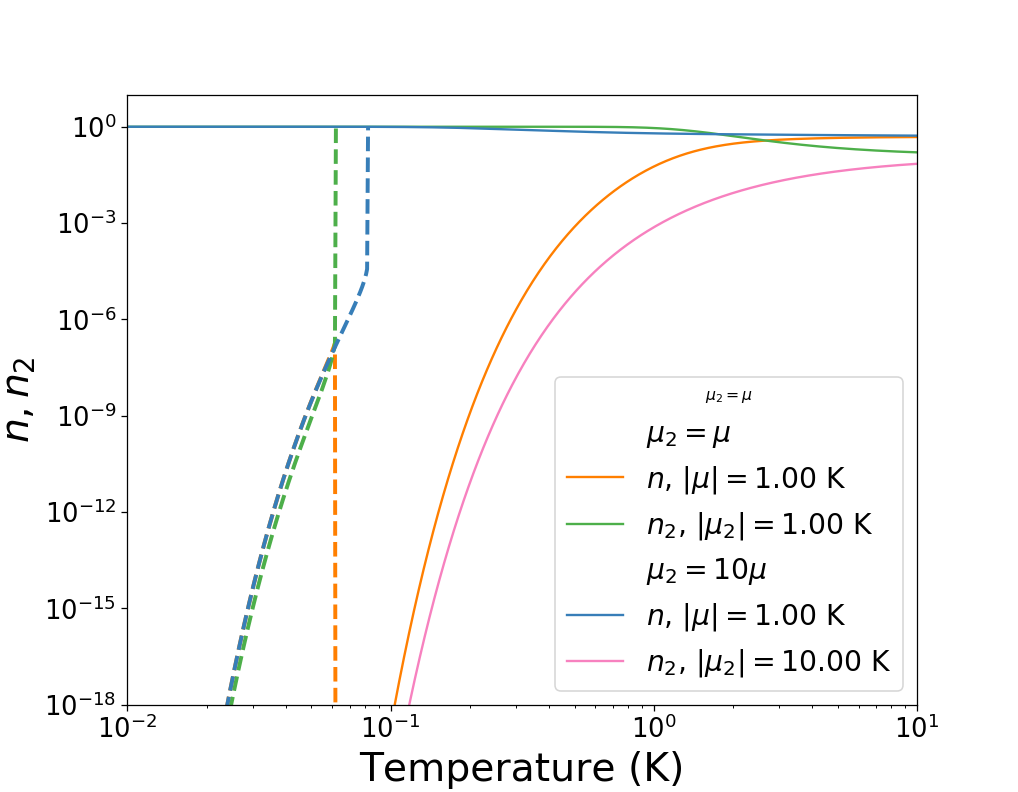

Population inversion combined graph 2.eps


In [18]:
###Monopole Crossover###
graph1= plt.figure(figsize=(9,7))


#plt.plot(TempArray_double1[0:1000], nArray_double1[0:1000] , 'r-', label="$\mu=0.50$, heating")
#plt.plot(TempArray_double1[0:1000], n_2Array_double1[0:1000], 'b-', label="$\mu_2=0.50*$" + str(factor) + ", $n_2$ heating")

#plt.plot(TempArray_double1[1001:2000], nArray_double1[1001:2000] , 'r--', linewidth=2.5, label="$\mu=0.50$ cooling")
#plt.plot(TempArray_double1[1001:2000], n_2Array_double1[1001:2000], 'b--', linewidth=2.5, label="$\mu_2=0.50*$" + str(factor) + ", $n_2$ cooling")

###For the test runs###
plt.plot(TempArray_doubleInv[0:215], nArray_doubleInv[0:215], color='#ff7f00', linestyle='--', linewidth=2.5)#, label="$n$, $|\mu|=1.00$ K")
plt.plot(TempArray_doubleInv[0:215], n_2Array_doubleInv[0:215], color='#4daf4a', linestyle='--', linewidth=2.5)#, label="$n_2$, $|\mu_2|=4.00$ K")

#0 ---> 215 for mu = 1.00, mu_2 =1.00
#0 ---> 248 for mu = 1.00, mu_2 =4.00
#0 ---> 248 for mu = 1.00, mu_2 =10.00

p5, = plt.plot([0], marker='None', linestyle='None', label=r'$\mu_2=\mu$')

p1 = plt.plot(TempArray_doubleInv[1001:2000], nArray_doubleInv[1001:2000] , color='#ff7f00', linestyle='-', label="$n$, $|\mu|=1.00$ K")
p2 = plt.plot(TempArray_doubleInv[1001:2000], n_2Array_doubleInv[1001:2000], color='#4daf4a', linestyle='-', label="$n_2$, $|\mu_2|=1.00$ K")
         #"$\mu_2=1.00*$" + str(factor) + ", $n_2$")

###Second set
plt.plot(TempArray_doubleInv2[0:248], nArray_doubleInv2[0:248], color='#377eb8', linestyle='--', linewidth=2.5)#, label="$n$, $|\mu|=1.00$ K")
plt.plot(TempArray_doubleInv2[0:248], n_2Array_doubleInv2[0:248], color='#f781bf', linestyle='--', linewidth=2.5)#, label="$n_2$, $|\mu_2|=4.00$ K")

#0 ---> 215 for mu = 1.00, mu_2 =1.00
#0 ---> 248 for mu = 1.00, mu_2 =4.00
#0 ---> 248 for mu = 1.00, mu_2 =10.00


p6, = plt.plot([0], marker='None', linestyle='None', label="$\mu_2=10\mu$")

p3 = plt.plot(TempArray_doubleInv2[1001:2000], nArray_doubleInv2[1001:2000] , color='#377eb8', linestyle='-', label="$n$, $|\mu|=1.00$ K")
p4 = plt.plot(TempArray_doubleInv2[1001:2000], n_2Array_doubleInv2[1001:2000], color='#f781bf', linestyle='-', label="$n_2$, $|\mu_2|=10.00$ K")


#p5, = plt.plot([0], marker='None', linestyle='None', label='dummy-tophead')

plt.xlabel("Temperature (K)", size=25)
plt.ylabel("$n, n_2$", size=25)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=16.5)
plt.yticks(fontsize=16.5)
#1.57 crossover avoidance limits
#plt.ylim(10**-22,5*10**-1)
#plt.xlim(0.1,0.23)

#variable lim
plt.ylim(10**-18,1*10**1)
plt.xlim(0.01,10)

#plt.title(str(factor) + " factor monopole densities", size=20)
#plt.title("Hysteresis of monopole densities against temperature", size=20)

plt.legend(loc='lower right', fontsize=18, title='$\mu_2=\mu$')
#lgd = plt.legend(bbox_to_anchor=(-0.06, 1.17), ncol=2 ,loc='upper left', fontsize=16)

#first_set_labels = ["$\mu_2=\mu$", "$n$, $|\mu|=1.00$ K", "$n_2$, $|\mu_2|=1.00$ K"]
#second_set_labels = ["$\mu_2=10\mu$", "$n$, $|\mu|=1.00$ K", "$n_2$, $|\mu_2|=10.00$ K"]

#lgd = plt.legend([p5, p1, p2, p5, p3, p4], first_set_labels + second_set_labels, bbox_to_anchor=(-0.06, 1.17), ncol=2 ,loc='upper left', fontsize=16)

#graph_string = ' factor monopole inversion 1 mu PAPER markerless.eps'
#filename = invFac_string + graph_string
filename = "Population inversion combined graph 2.eps"
print(filename)
#plt.savefig(filename)

<IPython.core.display.Javascript object>


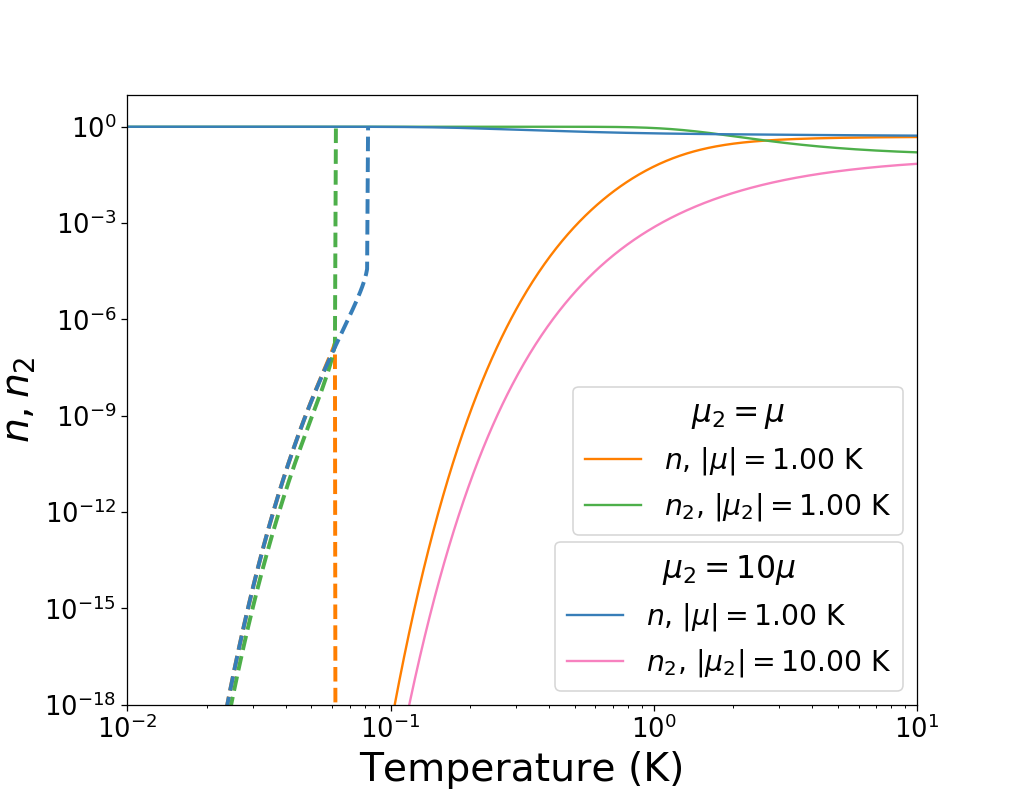

Population inversion combined graph 3.eps


In [32]:
###Monopole Crossover  2###
graph1= plt.figure(figsize=(9,7))

###For the test runs###
plt.plot(TempArray_doubleInv[0:215], nArray_doubleInv[0:215], color='#ff7f00', linestyle='--', linewidth=2.5)#, label="$n$, $|\mu|=1.00$ K")
plt.plot(TempArray_doubleInv[0:215], n_2Array_doubleInv[0:215], color='#4daf4a', linestyle='--', linewidth=2.5)#, label="$n_2$, $|\mu_2|=4.00$ K")

#0 ---> 215 for mu = 1.00, mu_2 =1.00
#0 ---> 248 for mu = 1.00, mu_2 =4.00
#0 ---> 248 for mu = 1.00, mu_2 =10.00

#p5, = plt.plot([0], marker='None', linestyle='None', label=r'$\mu_2=\mu$')

p1, = plt.plot(TempArray_doubleInv[1001:2000], nArray_doubleInv[1001:2000] , color='#ff7f00', linestyle='-', label="$n$, $|\mu|=1.00$ K")
p2, = plt.plot(TempArray_doubleInv[1001:2000], n_2Array_doubleInv[1001:2000], color='#4daf4a', linestyle='-', label="$n_2$, $|\mu_2|=1.00$ K")
         #"$\mu_2=1.00*$" + str(factor) + ", $n_2$")

###Second set
plt.plot(TempArray_doubleInv2[0:248], nArray_doubleInv2[0:248], color='#377eb8', linestyle='--', linewidth=2.5)#, label="$n$, $|\mu|=1.00$ K")
plt.plot(TempArray_doubleInv2[0:248], n_2Array_doubleInv2[0:248], color='#f781bf', linestyle='--', linewidth=2.5)#, label="$n_2$, $|\mu_2|=4.00$ K")

#0 ---> 215 for mu = 1.00, mu_2 =1.00
#0 ---> 248 for mu = 1.00, mu_2 =4.00
#0 ---> 248 for mu = 1.00, mu_2 =10.00


#p6, = plt.plot([0], marker='None', linestyle='None', label="$\mu_2=10\mu$")

p3, = plt.plot(TempArray_doubleInv2[1001:2000], nArray_doubleInv2[1001:2000] , color='#377eb8', linestyle='-', label="$n$, $|\mu|=1.00$ K")
p4, = plt.plot(TempArray_doubleInv2[1001:2000], n_2Array_doubleInv2[1001:2000], color='#f781bf', linestyle='-', label="$n_2$, $|\mu_2|=10.00$ K")

plt.xlabel("Temperature (K)", size=25)
plt.ylabel("$n, n_2$", size=25)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=16.5)
plt.yticks(fontsize=16.5)

first_legend = plt.legend(bbox_to_anchor=(1.00, 0.40), handles=[p1,p2], loc='center right',fontsize='18', title='$\mu_2=\mu$', title_fontsize=20)
ax = plt.gca().add_artist(first_legend)

#variable lim
plt.ylim(10**-18,1*10**1)
plt.xlim(0.01,10)

plt.legend(handles=[p3,p4], loc='lower right', fontsize=18, title='$\mu_2=10\mu$', title_fontsize=20)
#lgd = plt.legend(bbox_to_anchor=(-0.06, 1.17), ncol=2 ,loc='upper left', fontsize=16)

#graph_string = ' factor monopole inversion 1 mu PAPER markerless.eps'
#filename = invFac_string + graph_string
filename = "Population inversion combined graph 3.eps"
print(filename)
plt.savefig(filename)

In [ ]:
graph1= plt.figure(figsize=(9,7))
plt.grid(True)

plt.plot(TempArray_double1[0:1000], nArray_double1[0:1000]/n_2Array_double1[0:1000] , '-', label="$n/n_2$ $\mu=0.50$ heating")
plt.plot(TempArray_double1[1001:2000], nArray_double1[1001:2000]/n_2Array_double1[1001:2000] , '--', linewidth=3, label="$n/n_2$ $\mu=0.50$ cooling")

plt.title(str(factor) + " factor monopole density ratios against temperature", size=20)
plt.legend(loc='lower right', fontsize=18)

plt.xlabel("Temperature (K)", size=20)
plt.ylabel("$n/n_2$", size=20)

#plt.ylim(-0.1,4.5)
plt.ylim(0,15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

graph_string = ' factor monopole ratios hysteresis comparison.eps'
filename = factor_string + graph_string
print(filename)
plt.savefig(filename)

In [ ]:
print(n_2Array_double1[0:5])
print(nArray_double1[0:5])
print(n_2Array_double1[0:5]/nArray_double1[0:5])

In [ ]:
graph1= plt.figure()
plt.grid(True)

plt.plot(TempArray_double1, Omega_double1, '-', label="$\mu=0.50$, $n_2$")
plt.plot(TempArray_double9, Omega_double9, '-', label="$\mu=0.75$, $n_2$")
plt.plot(TempArray_double2, Omega_double2, '-', label="$\mu=1.00$, $n_2$")
plt.plot(TempArray_double3, Omega_double3, '-', label="$\mu=1.15$, $n_2$")
plt.plot(TempArray_double4, Omega_double4, '-', label="$\mu=1.30$, $n_2$")
plt.plot(TempArray_double5, Omega_double5, '-', label="$\mu=1.57$, $n_2$")
plt.plot(TempArray_double6, Omega_double6, '-', label="$\mu=1.90$, $n_2$")
plt.plot(TempArray_double7, Omega_double7, '-', label="$\mu=2.50$, $n_2$")
plt.plot(TempArray_double8, Omega_double8, '-', label="$\mu=4.35$, $n_2$")

plt.xlabel("Temperature (K)")
plt.ylabel("free energy per site")
#plt.yscale('log')
#plt.ylim(-50, 0)
#plt.xlim(0,5)
plt.title(str(factor) + " factor double model free energy against temperature")
plt.legend(loc='lower left')

graph_string = ' factor metastable free energy comparison.png'
filename = factor_string + graph_string
print(filename)
plt.savefig(filename)

In [ ]:
graph1= plt.figure()
plt.grid(True)

plt.plot(TempArray_double1, EntropyArray_double1, '-', label="$\mu=0.50$, $n_2$")
plt.plot(TempArray_double9, EntropyArray_double9, '-', label="$\mu=0.75$, $n_2$")
plt.plot(TempArray_double2, EntropyArray_double2, '-', label="$\mu=1.00$, $n_2$")
plt.plot(TempArray_double3, EntropyArray_double3, '-', label="$\mu=1.15$, $n_2$")
plt.plot(TempArray_double4, EntropyArray_double4, '-', label="$\mu=1.30$, $n_2$")
plt.plot(TempArray_double5, EntropyArray_double5, '-', label="$\mu=1.57$, $n_2$")
plt.plot(TempArray_double6, EntropyArray_double6, '-', label="$\mu=1.90$, $n_2$")
plt.plot(TempArray_double7, EntropyArray_double7, '-', label="$\mu=2.50$, $n_2$")
plt.plot(TempArray_double8, EntropyArray_double8, '-', label="$\mu=4.35$, $n_2$")

plt.xlabel("Temperature (K)")
plt.ylabel("entropy")
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(-50, 0)
#plt.xlim(0,5)
plt.title(str(factor) + " factor low density double model free energy against temperature")
plt.legend(loc='lower right')

graph_string = ' factor low density start entropy comparison.png'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)

In [ ]:
###corrected chemical potential aginst temperature single monopoles###
graph1 = plt.figure()
plt.grid(True)


plt.plot(TempArray_double1, muDoubleArray1/((k_B)*-0.50), '-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray_double9, muDoubleArray9/((k_B)*-0.75), '-', linewidth=1, label="$\mu=-0.75$ K")
plt.plot(TempArray_double2, muDoubleArray2/((k_B)*-1.00), '-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray_double3, muDoubleArray3/((k_B)*-1.15), '-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray_double4, muDoubleArray4/((k_B)*-1.30), 'b-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray_double5, muDoubleArray5/((k_B)*-1.57), 'g-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray_double6, muDoubleArray6/((k_B)*-1.90), '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray_double7, muDoubleArray7/((k_B)*-2.50), '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray_double8, muDoubleArray8/((k_B)*-4.35), 'r-', linewidth=1, label="$\mu=-4.35$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Effective chemical potential/bare chemical potential")
#plt.yscale('log')
plt.xlim(0,2.0)
#plt.ylim(0, 0.6)
plt.title("Reduced chemical potential of single monoples against temperature")
plt.legend(loc='upper right')
#plt.savefig("Reduced chemical potential for single monopoles against temperature.png")

In [ ]:
###corrected chemical potential aginst temperature single monopoles###
graph1 = plt.figure()
plt.grid(True)

plt.plot(TempArray_double1, mu2DoubleArray1/((k_B)*2*-0.50), '-', linewidth=1, label="$\mu_2=-0.50*2$ K")
plt.plot(TempArray_double9, mu2DoubleArray9/((k_B)*2*-0.75), '-', linewidth=1, label="$\mu_2=-0.75*2$ K")
plt.plot(TempArray_double2, mu2DoubleArray2/((k_B)*2*-1.00), '-', linewidth=1, label="$\mu_2=-1.00*2$ K")
plt.plot(TempArray_double3, mu2DoubleArray3/((k_B)*2*-1.15), '-', linewidth=1, label="$\mu_2=-1.15*2$ K")
plt.plot(TempArray_double4, mu2DoubleArray4/((k_B)*2*-1.30), 'b-', linewidth=1, label="$\mu_2=-1.30*2$ K")
plt.plot(TempArray_double5, mu2DoubleArray5/((k_B)*2*-1.57), 'g-', linewidth=1, label="$\mu_2=-1.57*2$ K")
plt.plot(TempArray_double6, mu2DoubleArray6/((k_B)*2*-1.90), '-', linewidth=1, label="$\mu_2=-1.90*2$ K")
plt.plot(TempArray_double7, mu2DoubleArray7/((k_B)*2*-2.50), '-', linewidth=1, label="$\mu_2=-2.50*2$ K")
plt.plot(TempArray_double8, mu2DoubleArray8/((k_B)*2*-4.35), 'r-', linewidth=1, label="$\mu_2=-4.35*2$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Effective chemical potential/bare chemical potential")
#plt.yscale('log')
plt.xlim(0,2)
#plt.ylim(0, 3)
plt.title("Reduced chemical potential for double monopoles against temperature")
plt.legend(loc='upper right')
#plt.savefig("Reduced chemical potential for double monopoles against temperature.png")

In [ ]:
print(TempArray_double1[0:1000])

In [7]:
###specific heat against temperature double model###
graph1 = plt.figure(figsize=(9,7))
ax = plt.subplot(111)
#-plt.grid(True)


#plt.plot(TempArray_double1[0:1000], SpecHeatArray_double1[0:1000]/((k_B)*N_0), 'b--', linewidth=2.5)#, label="$\mu=-0.50$ K")# heating")
#plt.plot(TempArray_double9[0:1000], SpecHeatArray_double9[0:1000]/((k_B)*N_0), 'r--', linewidth=2.5)#, label="$\mu=-0.75$ K")# heating")
#plt.plot(TempArray_double2[0:1000], SpecHeatArray_double2[0:1000]/((k_B)*N_0), 'g--', linewidth=2.5)#, label="$\mu=-1.00$ K")# heating")
#plt.plot(TempArray_double3[0:1000], SpecHeatArray_double3[0:1000]/((k_B)*N_0), '--', linewidth=2.5)#, label="$\mu=-1.15$ K")# heating")
#plt.plot(TempArray_double4[0:1000], SpecHeatArray_double4[0:1000]/((k_B)*N_0), 'r--', linewidth=2.5)#, label="$\mu=-1.30$ K")# heating")
plt.plot(TempArray_double5[300:326], SpecHeatArray_double5[300:326]/((k_B)*N_0), color='#4daf4a', linestyle='--', linewidth=2.5)#, label="$\mu=-1.57$ K")# heating")
#plt.plot(TempArray_double6[0:1000], SpecHeatArray_double6[0:1000]/((k_B)*N_0), 'm--', linewidth=2.5)#, label="$\mu=-1.90$ K")# heating")
#plt.plot(TempArray_double7[0:1000], SpecHeatArray_double7[0:1000]/((k_B)*N_0), 'b--', linewidth=2.5)#, label="$\mu=-2.50$ K")# heating")
#plt.plot(TempArray_double8[0:1000], SpecHeatArray_double8[0:1000]/((k_B)*N_0), 'k--', linewidth=2.5)#, label="$\mu=-4.35$ K")# heating")

#plt.plot(TempArray_double1[1001:2000], SpecHeatArray_double1[1001:2000]/((k_B)*N_0), 'b-', linewidth=1, label="$|\mu|=0.50$ K")
plt.plot(TempArray_double9[1001:2000], SpecHeatArray_double9[1001:2000]/((k_B)*N_0), color='#ff7f00', linestyle='-', linewidth=1, label="$|\mu|=0.75$ K")
#plt.plot(TempArray_double2[1001:2000], SpecHeatArray_double2[1001:2000]/((k_B)*N_0), 'g-', linewidth=1, label="$|\mu|=1.00$ K")
#plt.plot(TempArray_double3[1001:2000], SpecHeatArray_double3[1001:2000]/((k_B)*N_0), '-', linewidth=1, label="$|\mu|=1.15$ K")
#plt.plot(TempArray_double4[1001:2000], SpecHeatArray_double4[1001:2000]/((k_B)*N_0), 'r-', linewidth=1, label="$|\mu|=1.30$ K")
plt.plot(TempArray_double5[1001:2000], SpecHeatArray_double5[1001:2000]/((k_B)*N_0), color='#4daf4a', linestyle='-', linewidth=1, label="$|\mu|=1.57$ K")
#plt.plot(TempArray_double6[1001:2000], SpecHeatArray_double6[1001:2000]/((k_B)*N_0), 'm-', linewidth=1, label="$|\mu|=1.90$ K")
plt.plot(TempArray_double7[1001:2000], SpecHeatArray_double7[1001:2000]/((k_B)*N_0), color='#377eb8', linestyle='-', linewidth=1, label="$|\mu|=2.50$ K")
plt.plot(TempArray_double8[1001:2000], SpecHeatArray_double8[1001:2000]/((k_B)*N_0), 'k-', linewidth=1, label="$|\mu|=4.35$ K")

plt.xlabel("Temperature (K)", size=25)
plt.ylabel("Specific heat ($K^{-2}mol^{-1}$)", size=25)
plt.xscale('log')
plt.xlim(0.01,2)
#plt.ylim(0, 0.6)
plt.xticks([0.01,0.1,1],['0.01','0.10','1.00'], fontsize=16.5)
plt.yticks(fontsize=16.5)
#plt.title(str(factor) + " factor specific heat hysteresis against temperature", size=20)
plt.legend(loc='upper left', fontsize=25)#, bbox_to_anchor=(1.36, 1))

# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

graph_string = ' factor specific heat hysteresis markerless PAPER.eps'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)

<IPython.core.display.Javascript object>

NameError: name 'gapminder_us' is not defined

In [ ]:
###reduced specific heat against temperature double model###
graph1 = plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.grid(True)


plt.plot(TempArray_double1[0:1000], SpecHeatArray_double1[0:1000]/((k_B)*N_0*TempArray_double1[0:1000]), 'b-', linewidth=1, label="$\mu=-0.50$ K")# heating")
#plt.plot(TempArray_double9[0:1000], SpecHeatArray_double9[0:1000]/((k_B)*N_0*TempArray_double9[0:1000]), '-', linewidth=1, label="$\mu=-0.75$ K")# heating")
#plt.plot(TempArray_double2[0:1000], SpecHeatArray_double2[0:1000]/((k_B)*N_0*TempArray_double2[0:1000]), 'g-', linewidth=1, label="$\mu=-1.00$ K")# heating")
#plt.plot(TempArray_double3[0:1000], SpecHeatArray_double3[0:1000]/((k_B)*N_0*TempArray_double3[0:1000]), '-', linewidth=1, label="$\mu=-1.15$ K")# heating")
#plt.plot(TempArray_double4[0:1000], SpecHeatArray_double4[0:1000]/((k_B)*N_0*TempArray_double4[0:1000]), 'r-', linewidth=1, label="$\mu=-1.30$ K")# heating")
plt.plot(TempArray_double5[0:1000], SpecHeatArray_double5[0:1000]/((k_B)*N_0*TempArray_double5[0:1000]), 'c-', linewidth=1, label="$\mu=-1.57$ K")# heating")
#plt.plot(TempArray_double6[0:1000], SpecHeatArray_double6[0:1000]/((k_B)*N_0*TempArray_double6[0:1000]), 'm-', linewidth=1, label="$\mu=-1.90$ K")# heating")
#plt.plot(TempArray_double7[0:1000], SpecHeatArray_double7[0:1000]/((k_B)*N_0*TempArray_double7[0:1000]), '-', linewidth=1, label="$\mu=-2.50$ K")# heating")
plt.plot(TempArray_double8[0:1000], SpecHeatArray_double8[0:1000]/((k_B)*N_0*TempArray_double8[0:1000]), 'k-', linewidth=1, label="$\mu=-4.35$ K")# heating")

plt.plot(TempArray_double1[1001:2000], SpecHeatArray_double1[1001:2000]/((k_B)*N_0*TempArray_double1[1001:2000]), 'b--', linewidth=2)#, label="$\mu=-0.50$ K cooling")
#plt.plot(TempArray_double9[1001:2000], SpecHeatArray_double9[1001:2000]/((k_B)*N_0*TempArray_double9[1001:2000]), '--', linewidth=2)#, label="$\mu=-0.75$ K cooling")
#plt.plot(TempArray_double2[1001:2000], SpecHeatArray_double2[1001:2000]/((k_B)*N_0*TempArray_double2[1001:2000]), 'g--', linewidth=2)#, label="$\mu=-1.00$ K cooling")
#plt.plot(TempArray_double3[1001:2000], SpecHeatArray_double3[1001:2000]/((k_B)*N_0*TempArray_double3[1001:2000]), '--', linewidth=2)#, label="$\mu=-1.15$ K cooling")
#plt.plot(TempArray_double4[1001:2000], SpecHeatArray_double4[1001:2000]/((k_B)*N_0*TempArray_double4[1001:2000]), 'r--', linewidth=2)#, label="$\mu=-1.30$ K cooling")
plt.plot(TempArray_double5[1001:2000], SpecHeatArray_double5[1001:2000]/((k_B)*N_0*TempArray_double5[1001:2000]), 'c--', linewidth=2)#, label="$\mu=-1.57$ K cooling")
#plt.plot(TempArray_double6[1001:2000], SpecHeatArray_double6[1001:2000]/((k_B)*N_0*TempArray_double6[1001:2000]), 'm--', linewidth=2)#, label="$\mu=-1.90$ K cooling")
#plt.plot(TempArray_double7[1001:2000], SpecHeatArray_double7[1001:2000]/((k_B)*N_0*TempArray_double7[1001:2000]), '--', linewidth=2)#, label="$\mu=-2.50$ K cooling")
plt.plot(TempArray_double8[1001:2000], SpecHeatArray_double8[1001:2000]/((k_B)*N_0*TempArray_double8[1001:2000]), 'k--', linewidth=2)#, label="$\mu=-4.35$ K cooling")

plt.xlabel("Temperature (K)", size=20)
plt.ylabel("Specific heat/temperature ($K^{-3}mol^{-1}$)", size=20)
plt.xscale('log')
plt.xlim(0,2.0)
#plt.ylim(0, 0.6)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(str(factor) + " factor specific heat/temperature hysteresis", size=20)
plt.legend(loc='upper right', fontsize=15, bbox_to_anchor=(1.36, 1))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

graph_string = ' factor specific heat over temperature hysteresis comparison.png'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)

In [ ]:
graph1 = plt.figure(figsize=(9,7))
#ax = plt.subplot(111)
#plt.grid(True)


#plt.plot(TempArray_double1[0:1000], EntropyArray_double1[0:1000], 'b--', linewidth=2)#, label="$\mu=-0.50$ K heating")
plt.plot(TempArray_double9[0:203], EntropyArray_double9[0:203], color='#ff7f00', linestyle='--', linewidth=2.5)#, label="$\mu=-0.75$ K heating")
#plt.plot(TempArray_double2[0:1000], EntropyArray_double2[0:1000], 'g--', linewidth=2)#, label="$\mu=-1.00$ K heating")
#plt.plot(TempArray_double3[0:1000], EntropyArray_double3[0:1000], '--', linewidth=2)#, label="$\mu=-1.15$ K heating")
#plt.plot(TempArray_double4[0:1000], EntropyArray_double4[0:1000], 'r--', linewidth=2)#, label="$\mu=-1.30$ K heating")
plt.plot(TempArray_double5[303:326], EntropyArray_double5[303:326], color='#4daf4a', linestyle='--', linewidth=2.5)#, label="$\mu=-1.57$ K heating")
#plt.plot(TempArray_double6[0:1000], EntropyArray_double6[0:1000], 'm--', linewidth=2)#, label="$\mu=-1.90$ K heating")
#plt.plot(TempArray_double7[0:1000], EntropyArray_double7[0:1000], 'b--', linewidth=2)#, label="$\mu=-2.50$ K heating")
#plt.plot(TempArray_double8[0:1000], EntropyArray_double8[0:1000], 'k--', linewidth=2)#, label="$\mu=-4.35$ K heating")

#plt.plot(TempArray_double1[1001:2000], EntropyArray_double1[1001:2000], 'b-', linewidth=1, label="$|\mu|=0.50$ K")
plt.plot(TempArray_double9[1001:2000], EntropyArray_double9[1001:2000], color='#ff7f00', linestyle='-', linewidth=1, label="$|\mu|=0.75$ K")
#plt.plot(TempArray_double2[1001:2000], EntropyArray_double2[1001:2000], 'g-', linewidth=1, label="$|\mu|=1.00$ K")
#plt.plot(TempArray_double3[1001:2000], EntropyArray_double3[1001:2000], '-', linewidth=1, label="$|\mu|=1.15$ K")
#plt.plot(TempArray_double4[1001:2000], EntropyArray_double4[1001:2000], 'r-', linewidth=1, label="$|\mu|=1.30$ K")
plt.plot(TempArray_double5[1001:2000], EntropyArray_double5[1001:2000], color='#4daf4a', linestyle='-', linewidth=1, label="$|\mu|=1.57$ K")
#plt.plot(TempArray_double6[1001:2000], EntropyArray_double6[1001:2000], 'm-', linewidth=1, label="$|\mu|=1.90$ K")
plt.plot(TempArray_double7[1001:2000], EntropyArray_double7[1001:2000], color='#377eb8', linestyle='-', linewidth=1, label="$|\mu|=2.50$ K")
plt.plot(TempArray_double8[1001:2000], EntropyArray_double8[1001:2000], 'k-', linewidth=1, label="$|\mu|=4.35$ K")

plt.xlabel("Temperature (K)", size=25)
plt.ylabel("Entropy (J/Kmol)", size=25)
plt.xscale('log')
plt.xlim(0.01,2)
plt.ylim(-6, 12)
plt.xticks([0.01,0.1,1],['0.01','0.10','1.00'], fontsize=16.5)
plt.yticks(fontsize=16.5)
#plt.title(str(factor) + " factor entropy hysteresis", size=20)
plt.legend(loc='upper left', fontsize=23)

# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

graph_string = ' factor entropy hysteresis comparison markerless PAPER.eps'
filename = factor_string + graph_string
print(filename)
plt.savefig(filename)

<IPython.core.display.Javascript object>


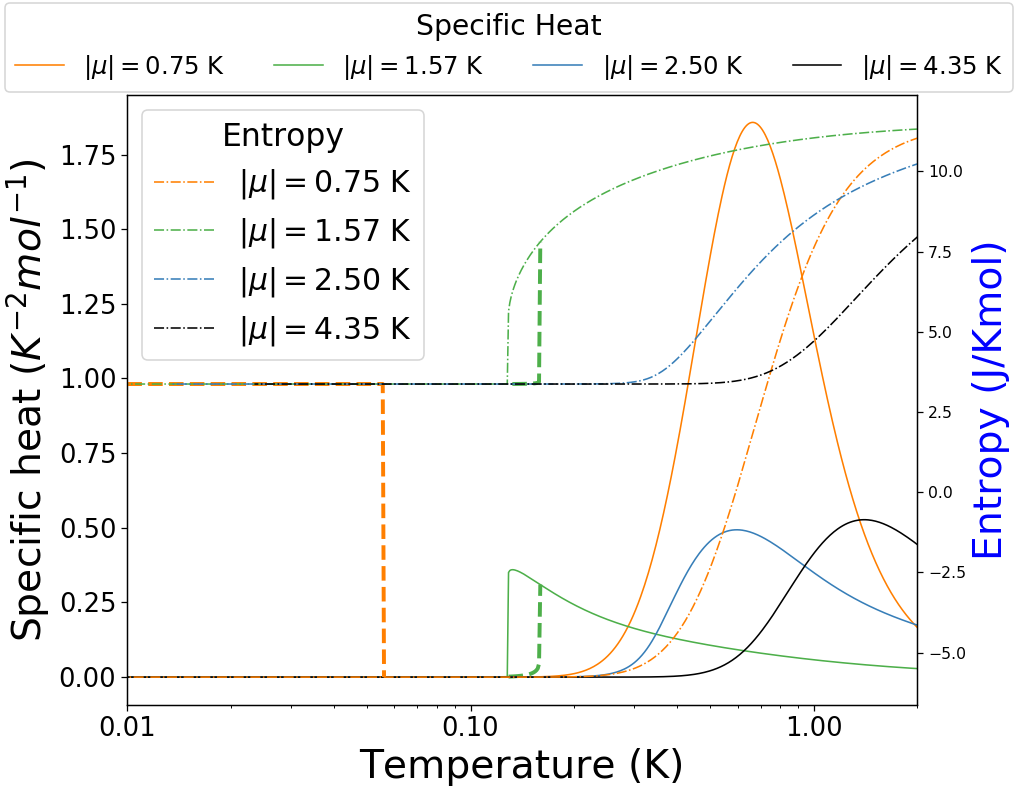

4 factor specific heat entropy combined PAPER.eps


In [41]:
###specific heat + entropy double model graph###
graph1 = plt.figure(figsize=(9,7))
ax = plt.subplot(111)
#-plt.grid(True)

#plt.plot([0], marker='None', linestyle='None', label=r'/bold{Specific heat}')

plt.plot(TempArray_double5[300:326], SpecHeatArray_double5[300:326]/((k_B)*N_0), color='#4daf4a', linestyle='--', linewidth=2.5)#, label="$\mu=-1.57$ K")# heating")

plt.plot(TempArray_double9[1001:2000], SpecHeatArray_double9[1001:2000]/((k_B)*N_0), color='#ff7f00', linestyle='-', linewidth=1, label="$|\mu|=0.75$ K")
plt.plot(TempArray_double5[1001:2000], SpecHeatArray_double5[1001:2000]/((k_B)*N_0), color='#4daf4a', linestyle='-', linewidth=1, label="$|\mu|=1.57$ K")
plt.plot(TempArray_double7[1001:2000], SpecHeatArray_double7[1001:2000]/((k_B)*N_0), color='#377eb8', linestyle='-', linewidth=1, label="$|\mu|=2.50$ K")
plt.plot(TempArray_double8[1001:2000], SpecHeatArray_double8[1001:2000]/((k_B)*N_0), 'k-', linewidth=1, label="$|\mu|=4.35$ K")

plt.xlabel("Temperature (K)", size=25)
plt.ylabel("Specific heat ($K^{-2}mol^{-1}$)", size=25)
plt.xscale('log')
plt.xlim(0.01,2)
#plt.ylim(0, 0.6)
plt.xticks([0.01,0.1,1],['0.01','0.10','1.00'], fontsize=16.5)
plt.yticks(fontsize=16.5)
#plt.title(str(factor) + " factor specific heat hysteresis against temperature", size=20)
plt.legend(bbox_to_anchor=(-0.17, 1.17), ncol=4 ,loc='upper left', fontsize=15.5, title='Specific Heat', title_fontsize=18)

###second axis plots
ax2=ax.twinx()

#ax2.plot([0], marker='None', linestyle='None', label=r'$Entropy$')

ax2.plot(TempArray_double9[0:203], EntropyArray_double9[0:203], color='#ff7f00', linestyle='--', linewidth=2.5)#, label="$\mu=-0.75$ K heating")
ax2.plot(TempArray_double5[303:326], EntropyArray_double5[303:326], color='#4daf4a', linestyle='--', linewidth=2.5)#, label="$\mu=-1.57$ K heating")

ax2.plot(TempArray_double9[1001:2000], EntropyArray_double9[1001:2000], color='#ff7f00', linestyle='-.', linewidth=1, label="$|\mu|=0.75$ K")
ax2.plot(TempArray_double5[1001:2000], EntropyArray_double5[1001:2000], color='#4daf4a', linestyle='-.', linewidth=1, label="$|\mu|=1.57$ K")
ax2.plot(TempArray_double7[1001:2000], EntropyArray_double7[1001:2000], color='#377eb8', linestyle='-.', linewidth=1, label="$|\mu|=2.50$ K")
ax2.plot(TempArray_double8[1001:2000], EntropyArray_double8[1001:2000], 'k-.', linewidth=1, label="$|\mu|=4.35$ K")

ax2.legend(loc='upper left', fontsize=19, title='Entropy', title_fontsize=20)

ax2.set_ylabel("Entropy (J/Kmol)",color="blue",fontsize=25)

# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

graph_string = ' factor specific heat entropy combined PAPER.eps'
filename = factor_string + graph_string
print(filename)
plt.savefig(filename)

In [ ]:
print(EntropyArray_double1[0:1000])

In [ ]:
print(nArray_double1[0:1000])


In [ ]:
print(n_2Array_double1[0:1000])

In [ ]:
print(SpecHeatArray_double9[0:1000])

In [ ]:
###reduced chemical potential against temperature single monopoles###
graph1 = plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.grid(True)


plt.plot(TempArray_double1[0:1000], muDoubleArray1[0:1000]/((k_B)*-0.50), 'b-', linewidth=1, label="$\mu=-0.50$ K")# heating")
#plt.plot(TempArray_double9[0:1000], muDoubleArray9[0:1000]/((k_B)*-0.75), '-', linewidth=1, label="$\mu=-0.75$ K")# heating")
plt.plot(TempArray_double2[0:1000], muDoubleArray2[0:1000]/((k_B)*-1.00), 'g-', linewidth=1, label="$\mu=-1.00$ K")# heating")
#plt.plot(TempArray_double3[0:1000], muDoubleArray3[0:1000]/((k_B)*-1.15), '-', linewidth=1, label="$\mu=-1.15$ K")# heating")
plt.plot(TempArray_double4[0:1000], muDoubleArray4[0:1000]/((k_B)*-1.30), 'r-', linewidth=1, label="$\mu=-1.30$ K")# heating")
plt.plot(TempArray_double5[0:1000], muDoubleArray5[0:1000]/((k_B)*-1.57), 'c-', linewidth=1, label="$\mu=-1.57$ K")# heating")
plt.plot(TempArray_double6[0:1000], muDoubleArray6[0:1000]/((k_B)*-1.90), 'm-', linewidth=1, label="$\mu=-1.90$ K")# heating")
#plt.plot(TempArray_double7[0:1000], muDoubleArray7[0:1000]/((k_B)*-2.50), '-', linewidth=1, label="$\mu=-2.50$ K")# heating")
plt.plot(TempArray_double8[0:1000], muDoubleArray8[0:1000]/((k_B)*-4.35), 'y-', linewidth=1, label="$\mu=-4.35$ K")# heating")

plt.plot(TempArray_double1[1001:2000], muDoubleArray1[1001:2000]/((k_B)*-0.50), 'b--', linewidth=2)#, label="$\mu=-0.50$ K cooling")
#plt.plot(TempArray_double9[1001:2000], muDoubleArray9[1001:2000]/((k_B)*-0.75), '--', linewidth=2)#, label="$\mu=-0.75$ K cooling")
plt.plot(TempArray_double2[1001:2000], muDoubleArray2[1001:2000]/((k_B)*-1.00), 'g--', linewidth=2)#, label="$\mu=-1.00$ K cooling")
#plt.plot(TempArray_double3[1001:2000], muDoubleArray3[1001:2000]/((k_B)*-1.15), '--', linewidth=2)#, label="$\mu=-1.15$ K cooling")
plt.plot(TempArray_double4[1001:2000], muDoubleArray4[1001:2000]/((k_B)*-1.30), 'r--', linewidth=2)#, label="$\mu=-1.30$ K cooling")
plt.plot(TempArray_double5[1001:2000], muDoubleArray5[1001:2000]/((k_B)*-1.57), 'c--', linewidth=2)#, label="$\mu=-1.57$ K cooling")
plt.plot(TempArray_double6[1001:2000], muDoubleArray6[1001:2000]/((k_B)*-1.90), 'm--', linewidth=2)#, label="$\mu=-1.90$ K cooling")
#plt.plot(TempArray_double7[1001:2000], muDoubleArray7[1001:2000]/((k_B)*-2.50), '--', linewidth=2)#, label="$\mu=-2.50$ K cooling")
plt.plot(TempArray_double8[1001:2000], muDoubleArray8[1001:2000]/((k_B)*-4.35), 'y--', linewidth=2)#, label="$\mu=-4.35$ K cooling")

plt.xlabel("Temperature (K)", size=20)
plt.ylabel("Reduced chemical potential", size=20)
#plt.yscale('log')
plt.xlim(0,2.0)
#plt.ylim(0, 0.6)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(str(factor) + " factor reduced chemical potential $\mu$ hysteresis", size=20)
plt.legend(loc='upper right', fontsize=15, bbox_to_anchor=(1.36, 1))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

graph_string = ' factor single monopoles reduced chemical potential hysteresis comparison.eps'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)

In [ ]:
###reduced chemical potential against temperature single monopoles###
graph1 = plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.grid(True)


plt.plot(TempArray_double1[0:1000], mu2DoubleArray1[0:1000]/((k_B)*factor*-0.50), 'b-', linewidth=1, label="$\mu_2=-0.50*4$ K")# heating")
#plt.plot(TempArray_double9[0:1000], mu2DoubleArray9[0:1000]/((k_B)*factor*-0.75), '-', linewidth=1, label="$\mu_2=-0.75*4$ K")# heating")
plt.plot(TempArray_double2[0:1000], mu2DoubleArray2[0:1000]/((k_B)*factor*-1.00), 'g-', linewidth=1, label="$\mu_2=-1.00*4$ K")# heating")
#plt.plot(TempArray_double3[0:1000], mu2DoubleArray3[0:1000]/((k_B)*factor*-1.15), '-', linewidth=1, label="$\mu_2=-1.15*4$ K")# heating")
plt.plot(TempArray_double4[0:1000], mu2DoubleArray4[0:1000]/((k_B)*factor*-1.30), 'r-', linewidth=1, label="$\mu_2=-1.30*4$ K")# heating")
plt.plot(TempArray_double5[0:1000], mu2DoubleArray5[0:1000]/((k_B)*factor*-1.57), 'c-', linewidth=1, label="$\mu_2=-1.57*4$ K")# heating")
plt.plot(TempArray_double6[0:1000], mu2DoubleArray6[0:1000]/((k_B)*factor*-1.90), 'm-', linewidth=1, label="$\mu_2=-1.90*4$ K")# heating")
#plt.plot(TempArray_double7[0:1000], mu2DoubleArray7[0:1000]/((k_B)*factor*-2.50), '-', linewidth=1, label="$\mu_2=-2.50*4$ K")# heating")
plt.plot(TempArray_double8[0:1000], mu2DoubleArray8[0:1000]/((k_B)*factor*-4.35), 'y-', linewidth=1, label="$\mu_2=-4.35*4$ K")# heating")

plt.plot(TempArray_double1[1001:2000], mu2DoubleArray1[1001:2000]/((k_B)*factor*-0.50), 'b--', linewidth=2)#, label="$\mu_2=-0.50*4$ K cooling")
#plt.plot(TempArray_double9[1001:2000], mu2DoubleArray9[1001:2000]/((k_B)*factor*-0.75), '--', linewidth=2)#, label="$\mu_2=-0.75*4$ K cooling")
plt.plot(TempArray_double2[1001:2000], mu2DoubleArray2[1001:2000]/((k_B)*factor*-1.00), 'g--', linewidth=2)#, label="$\mu_2=-1.00*4$ K cooling")
#plt.plot(TempArray_double3[1001:2000], mu2DoubleArray3[1001:2000]/((k_B)*factor*-1.15), '--', linewidth=2)#, label="$\mu_2=-1.15*4$ K cooling")
plt.plot(TempArray_double4[1001:2000], mu2DoubleArray4[1001:2000]/((k_B)*factor*-1.30), 'r--', linewidth=2)#, label="$\mu_2=-1.30*4$ K cooling")
plt.plot(TempArray_double5[1001:2000], mu2DoubleArray5[1001:2000]/((k_B)*factor*-1.57), 'c--', linewidth=2)#, label="$\mu_2=-1.57*4$ K cooling")
plt.plot(TempArray_double6[1001:2000], mu2DoubleArray6[1001:2000]/((k_B)*factor*-1.90), 'm--', linewidth=2)#, label="$\mu_2=-1.90*4$ K cooling")
#plt.plot(TempArray_double7[1001:2000], mu2DoubleArray7[1001:2000]/((k_B)*factor*-2.50), '--', linewidth=2)#, label="$\mu_2=-2.50*4$ K cooling")
plt.plot(TempArray_double8[1001:2000], mu2DoubleArray8[1001:2000]/((k_B)*factor*-4.35), 'y--', linewidth=2)#, label="$\mu_2=-4.35*4$ K cooling")

plt.xlabel("Temperature (K)", size=20)
plt.ylabel("Reduced chemical potential", size=20)
#plt.yscale('log')
plt.xlim(0,2.0)
#plt.ylim(0, 0.6)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(str(factor) + " factor reduced chemical potential $\mu_2$ hysteresis", size=20)
plt.legend(loc='center right', fontsize=15, bbox_to_anchor=(1.37, 0.4))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

graph_string = ' factor double monopole reduced chemcial potential hysteresis comparison.eps'
filename = factor_string + graph_string
print(filename)
#plt.savefig(filename)